In [1]:
import os
import shutil
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Filter and copy max 100 images per class
original_path = 'diseases'
filtered_path = 'diseases-filter'
os.makedirs(filtered_path, exist_ok=True)

for class_name in os.listdir(original_path):
    class_dir = os.path.join(original_path, class_name)
    if not os.path.isdir(class_dir):
        continue  # skip non-folder entries

    target_class_dir = os.path.join(filtered_path, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img in image_files[:100]:  # Limit to 100
        shutil.copy2(os.path.join(class_dir, img), os.path.join(target_class_dir, img))

# Step 2: Use filtered data with ImageDataGenerator
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

train_data = datagen.flow_from_directory(
    filtered_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    filtered_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 6261 images belonging to 86 classes.
Found 1561 images belonging to 86 classes.


In [10]:
# Step 3: Save labels to labels.json
class_labels = train_data.class_indices  # Get the class labels from train_data
import json
# Convert the class labels dictionary to a format suitable for JSON
labels_json = {class_name: index for class_name, index in class_labels.items()}

# Save to labels.json file
with open('labels.json', 'w') as json_file:
    json.dump(labels_json, json_file)

print("Labels saved to 'labels.json'")

Labels saved to 'labels.json'


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Load base MobileNetV2 model without top layer
base_model = MobileNetV2(input_shape=(img_size, img_size, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze the convolutional base

# Add custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')  # Use number of classes from data
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping (optional)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # Increase for better accuracy
    callbacks=[early_stop]
)


Epoch 1/10
196/196 [==============================] - 374s 2s/step - loss: 2.7738 - accuracy: 0.3341 - val_loss: 1.1924 - val_accuracy: 0.6931
Epoch 2/10
196/196 [==============================] - 296s 2s/step - loss: 1.2328 - accuracy: 0.6473 - val_loss: 0.7459 - val_accuracy: 0.7803
Epoch 3/10
196/196 [==============================] - 314s 2s/step - loss: 0.8670 - accuracy: 0.7427 - val_loss: 0.6202 - val_accuracy: 0.8020
Epoch 4/10
196/196 [==============================] - 313s 2s/step - loss: 0.6817 - accuracy: 0.7890 - val_loss: 0.5429 - val_accuracy: 0.8373
Epoch 5/10
196/196 [==============================] - 224s 1s/step - loss: 0.5844 - accuracy: 0.8195 - val_loss: 0.5435 - val_accuracy: 0.8225
Epoch 6/10
196/196 [==============================] - 224s 1s/step - loss: 0.5038 - accuracy: 0.8368 - val_loss: 0.5114 - val_accuracy: 0.8277
Epoch 7/10
196/196 [==============================] - 239s 1s/step - loss: 0.4429 - accuracy: 0.8543 - val_loss: 0.4941 - val_accuracy: 0.8328

In [3]:
# Evaluate model
loss, accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {accuracy:.2f}")

# Save the trained model
model.save("plant_disease_model_mobilenetv2.h5")


49/49 [==============================] - 56s 1s/step - loss: 0.4764 - accuracy: 0.8392
Validation Accuracy: 0.84


1/1 [==============================] - 0s 374ms/step
57


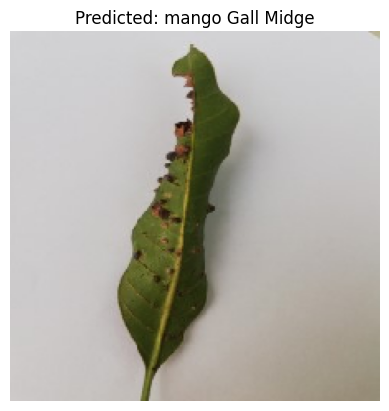

In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Example image path from filtered set
img_path = r"F:\diseases-filter\mango Gall Midge\IMG_20211106_161101 (Custom).jpg"
# Load image
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
predicted_class_index = np.argmax(pred)
predicted_class_label = list(train_data.class_indices.keys())[predicted_class_index]
print(predicted_class_index)
# Show result
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()
